In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import gpvisc


# Data Import

We first import some dataset, in wt%, in a Pandas DataFrame. Have a look at the file for an example.

In [2]:
db = pd.read_excel("./additional_data/compositions.xlsx")
db

,name,sio2,al2o3,feo,mgo,cao,na2o,k2o
0,P_Erebus,57.43,19.84,5.31,0.89,2.57,7.03,4.63
1,Andesite_Pele,59.70,18.30,7.58,2.59,7.21,3.44,0.90
2,MD_rhyo,76.74,13.03,0.89,0.05,0.41,3.43,5.36
3,MORB,50.47,14.70,10.43,7.58,11.39,2.79,0.16


we can convert the data in mol% using the `utils.wt_mol()` function. This functions expects a lot of chemical elements, that we should check and add using the `utils.chimie_control()` function first:

In [3]:
db = gpvisc.chimie_control(db)
db_mol = gpvisc.wt_mol(db)

# Calculating Redox with different models

Using the compositions, which are a Phonolite, an Andesite, a Rhyolite and the MOR basalt, we can calculate the redox state of iron in them.

For now, we can try on the first composition, and plot the result against temperature.

We will use two models:
- KC1991 : Kress, V.C., Carmichael, I.S., 1991. Contributions to Mineralogy and Petrology 108, 82–92.
- B2018 : Borisov, A., Behrens, H., Holtz, F., 2018. Contrib Mineral Petrol 173, 98. 

Here we calculate the redox at an oxygen fugacity of the room air, so 0.21.

For temperature, we define an axis that goes from 500 to 2000 K.

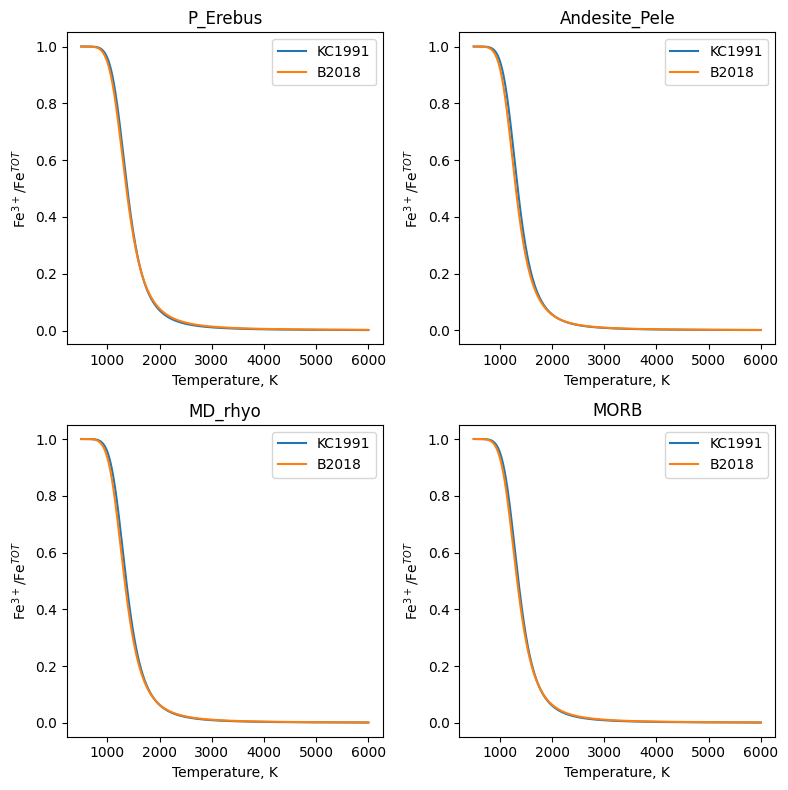

In [4]:
T = np.arange(500, 6000, 1.0)

plt.figure(figsize=(8,8))
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(T, gpvisc.redox(db_mol.loc[i-1,:], 10**-6,T, model = "KC1991"), label="KC1991")
    plt.plot(T, gpvisc.redox(db_mol.loc[i-1,:], 10**-6,T, model = "B2018"), label="B2018")
    plt.title(db_mol.loc[i-1,"name"])
    plt.legend(loc="best")
    plt.xlabel("Temperature, K")
    plt.ylabel("Fe$^{3+}$/Fe$^{TOT}$")
plt.tight_layout()

# Reproducing the Figure 2 published in Le Losq et al., 2020, AGU Monograph

A more complex example: the user imputed 4 compositions in the 4 lines, but wants to know for each one how redox varies between 500 and 2500 K. We have to use littles tricks to do so, but this is not that hard to achieve:

In [5]:
T = np.arange(500,2500,1.0)

redox_air = np.zeros((len(T),len(db_mol["name"])))
redox_m5 = np.zeros((len(T),len(db_mol["name"])))

for index, row in db_mol.iterrows():
    redox_air[:,index] = gpvisc.redox_B2018(db_mol.loc[index,:],0.21,T)
    redox_m5[:,index] = gpvisc.redox_B2018(db_mol.loc[index,:],10**-7,T)


fo2 = np.arange(-15.0,6,0.1)

redox_1600K = np.zeros((len(fo2),len(db_mol["name"])))

for index, row in db_mol.iterrows():
    redox_1600K[:,index] = gpvisc.redox_B2018(db_mol.loc[index,:],10**fo2,1500)


## The figure

Text(0.5, 0, 'log$_{10}$ $f$O$_2$')

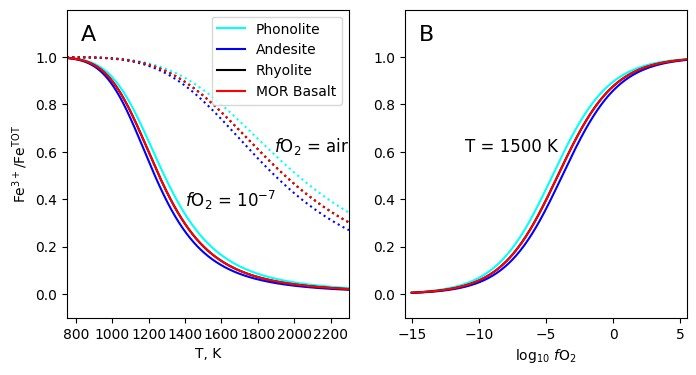

In [6]:
plt.figure(figsize=(8,4))

names=["Phonolite","Andesite","Rhyolite","MOR Basalt"]
colors = ["cyan","blue","black","red"]

plt.subplot(1,2,1) ######################################################################
plt.annotate("A",xy=(0.05,0.9),xycoords="axes fraction",fontsize=16)

for i in range(len(db_mol["name"])):
    plt.plot(T,redox_air[:,i],color=colors[i],linestyle=":")
    plt.plot(T,redox_m5[:,i],color=colors[i],linestyle="-",label=names[i])

plt.xlim(750,2300.)
plt.ylim(-0.1,1.2)

plt.yticks([0.,0.2,0.4,0.6,0.8,1.0])
plt.xticks([800.,1000.,1200.,1400.,1600.,1800.,2000.0,2200.])

plt.xlabel("T, K")
plt.ylabel(r"Fe$^{3+}$/Fe$^{\mathrm{TOT}}$")

plt.legend()

    
plt.annotate("$f$O$_2$ = air",xy=(2300,0.6),ha="right",xycoords="data",fontsize=12)
plt.annotate("$f$O$_2$ = 10$^{-7}$",xy=(1400,0.37),ha="left",xycoords="data",fontsize=12)

plt.subplot(1,2,2) ########################################################
plt.annotate("B",xy=(0.05,0.9),xycoords="axes fraction",fontsize=16)

for i in range(len(db_mol["name"])):
    plt.plot(fo2,redox_1600K[:,i],color=colors[i],linestyle="-")
    
plt.annotate("T = 1500 K",xy=(-11,0.6),xycoords="data",fontsize=12)

plt.xlim(-15.5,5.5)
plt.ylim(-0.1,1.2)
plt.yticks([0.,0.2,0.4,0.6,0.8,1.0])

plt.xlabel(r"log$_{10}$ $f$O$_2$")


# Now calculate viscosity as a function of redox 

### load the model 

In [7]:
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device="cpu")

### make a figure

We loop over two different temperatures and the four different compositions.

Calculations are made using the helper function `generate_query_single`. It takes care of everything for us, including weight-mol conversion and redox calculation.

Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...
Converting weight percent composition to mole fraction...
Calculation iron redox...


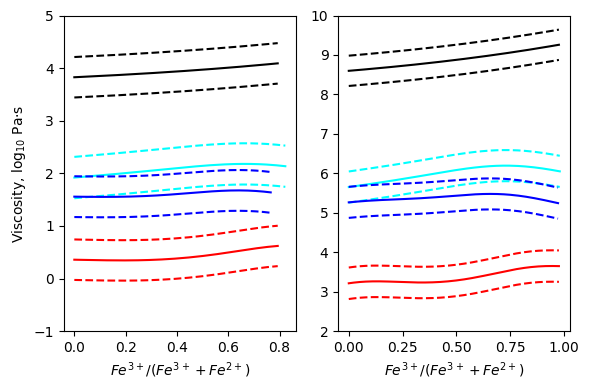

In [8]:
plt.figure(figsize=(6,4))
ax = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

for T in [1273, 1773.0]:

    for row_ in range(4):

        db_redox = gpvisc.generate_query_single(sio2=db.loc[row_, "sio2"],
                                     tio2=db.loc[row_, "tio2"],
                                     al2o3=db.loc[row_, "al2o3"],
                                     feo=db.loc[row_, "feo"],
                                     fe2o3=db.loc[row_, "fe2o3"],
                                     mno=db.loc[row_, "mno"],
                                     na2o=db.loc[row_, "na2o"],
                                     k2o=db.loc[row_, "k2o"],
                                     mgo=db.loc[row_, "mgo"],
                                     cao=db.loc[row_, "cao"],
                                     p2o5=db.loc[row_, "p2o5"],
                                     h2o=db.loc[row_, "h2o"],
                                     composition_mole = False,
                                     T_init = T, T_final= T,
                                     P_init = 0.0, P_final = 0.0,
                                     control_redox = True,
                                     fo2_init = -30.0, fo2_final = 1.0,
                                     redox_model="B2018",
                                     nb_values = 200,
                                     )

        # we recalculate the redox given the feo and fe2o3 columns
        feo_tot = db_redox["feo"]+db_redox["fe2o3"]*2.0
        redox_ = (2*db_redox["fe2o3"])/feo_tot

        # calculate the input for the GP
        X_redox = gpvisc.scale_for_gaussianprocess(db_redox["T"], 
                                                   db_redox["P"], 
                                                   db_redox)

        # predictions of the GP
        visco_mean, visco_std = gpvisc.predict(X_redox, gp_model, likelihood)
        
        # plotting
        if T == 1773:
            ax.plot(redox_, visco_mean, "-", color=colors[row_])
            ax.plot(redox_, visco_mean-visco_std, "--", color=colors[row_])
            ax.plot(redox_, visco_mean+visco_std, "--", color=colors[row_])
        else:
            ax2.plot(redox_, visco_mean, "-", color=colors[row_])
            ax2.plot(redox_, visco_mean-visco_std, "--", color=colors[row_])
            ax2.plot(redox_, visco_mean+visco_std, "--", color=colors[row_])

# general plottign details
ax.set_xlabel("$Fe^{3+}/(Fe^{3+}+Fe^{2+})$")
ax2.set_xlabel("$Fe^{3+}/(Fe^{3+}+Fe^{2+})$")
ax.set_ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
ax.set_ylim(-1,5)
ax2.set_ylim(2,10)
plt.tight_layout()
